In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from datetime import datetime
import os
import math

### Calcoli

In [26]:
# dati = pd.read_csv('bitcoin_data.csv')

dati = pd.read_csv('Bitcoin (€) da yfinance dal 17-09-2014 al 24-04-2024.csv')
dati.rename(columns={'Date':'Timestamp', 'Close':'Price'}, inplace=True)
dati = dati[['Timestamp', 'Price']]


dati['Timestamp'] = pd.to_datetime(dati['Timestamp'])
data_inizio = '2020-03-01'
data_fine = '2021-03-01'
# data_inizio = '2021-11-09'
# data_fine = '2022-12-01'
data1 = datetime.strptime(data_inizio, '%Y-%m-%d')
data2 = datetime.strptime(data_fine, '%Y-%m-%d')
lunghezza_periodo = (data2-data1).days

indice_inizio = dati[dati['Timestamp'] == data_inizio].index[0]

indice_fine = dati[dati['Timestamp'] == data_fine].index[0]

dati = dati[indice_inizio:indice_fine + 1]
dati = dati.reset_index(drop=True)

lista_guad = []
lista_guad_mdn = []
lista_guad_mdn_lun = []
lista_mdn = []
# lista_rendimenti_miei = []
lista_rendimenti_portafoglio = []
lista_rendimenti_spese = []
nome_variabile = 'timeframe'

numero_simulazioni = 30

def bitcoin_in_dollari(bitcoin, prezzo_bitcoin):
        return bitcoin * prezzo_bitcoin

def dollari_in_bitcoin(dollari, prezzo_bitcoin):
        return dollari / prezzo_bitcoin


for tempo_acquisto_VA in range(1, numero_simulazioni + 1):
    # Variabili
    strategia_giacomo = False
    perc_ritiro = 1
    tempo_controllo = lunghezza_periodo - 1 # Ogni quanti giorni controllo se c'è da ritirare l'eccesso dei soldi rispetto all'investimento_base
    fare_prima_VA = True # se è True, viene fatto prima (eventualmente) il value averaging e poi si ritira (eventualmente) la differenza tra i dollari posseduti su YP e l'investimento iniziale, altrimenti viceversa

    strategia_VA = True
    investimento_base = 0 # Quanti $ di bitcoin compro il primo giorno; è anche la soglia per sapere se ritirare l'eccesso dei soldi
    tempo_acquisto_VA = tempo_acquisto_VA # Ogni quanti giorni faccio in modo di comprare (o eventualmente vendere se vendita_VA = True) bitcoin in modo che il totale valga quanto stabilito dall'obiettivo di quel giorno (ad esempio potrei avere come obiettivo il secondo giorno 200$, il terzo giorno 300$ e così via)
    vendita_VA = True # se è True, significa che è possibile anche che si venda nel caso in cui il valore obiettivo del portafoglio di quel giorno debba essere inferiore a quello che in realtà ho già; se invece è False, in un caso del genere non si fa niente

    slittamento = 1 # Mi serve nel caso in cui voglio che l'obiettivo sia il prezzo stesso slittato di una certa quantità, ad esempio il prezzo del giorno precedente; se non viene usato, bisogna lasciarlo uguale a 1 per fare in modo che nella simulazione i calcoli partano dal giorno 1


    def calcola_obiettivo(t):
        # quanti = coef
        # massimo = max(dati['Price'].iloc[:t])
        # if t > quanti:
        #         massimo = max(dati['Price'].iloc[t-quanti:t])
        # return massimo - dati['Price'][t]
        return  0.1*dati['Price'][0]
    
    def calcola_prezzo(t):
       return dati['Price'][t]
    
    dati['Price'] = dati.index.map(calcola_prezzo)

    tabella_finale = dati.copy()

    dollari_in_banca = 100000
    deposito_YP = 0
    deposito_iniziale = 1000
    bitcoin_YP_iniziali = 0
    bitcoin_YP = bitcoin_YP_iniziali
    bitcoin_YP_in_dollari = bitcoin_in_dollari(bitcoin_YP, dati['Price'][0])
    perc_tassa_acquisto = 0.002
    liquidità_ist = 0
    liquidità_cumulativa = 0
    ricarica_cumulativa = 0
    obiettivo_cumulativo = 0
    tasse_pagate_ist = 0
    tasse_pagate = 0

    tabella_finale.rename(columns={'Timestamp': 'Data'}, inplace=True)
    tabella_finale.rename(columns={'Price': 'Prezzo bitcoin in $'}, inplace=True)

    # Creo delle colonne con dei valori solo allo scopo di creare queste colonne, per ora non sono importanti i valori
    tabella_finale['Deposito su YP in $'] = deposito_YP
    tabella_finale['Deposito su YP + liquidità cumulativa in $'] = deposito_YP + liquidità_cumulativa
    tabella_finale['Bitcoin su YP'] = bitcoin_YP
    tabella_finale['Bitcoin su YP in $'] = bitcoin_YP_in_dollari
    tabella_finale['Ritiro per strategia Giacomo in $'] = 0
    tabella_finale['Soldi in banca in $'] = dollari_in_banca
    tabella_finale['Vendita effettuata'] = False
    tabella_finale['Liquidità istantanea'] = liquidità_ist
    tabella_finale['Liquidità cumulativa'] = liquidità_cumulativa
    tabella_finale['Obiettivo'] = '-' # La popolo successivamente
    tabella_finale['Obiettivo "cumulativo"'] = 0 # La popolo successivamente
    tabella_finale['Obiettivo "cumulativo" - bitcoin su YP in $'] = 0
    tabella_finale['Deposito + bitcoin su YP + liquidità cumulativa in $'] = deposito_YP + bitcoin_YP_in_dollari + liquidità_cumulativa
    tabella_finale['Ricarica istantanea per VA'] = 0
    tabella_finale['Ricarica cumulativa per VA'] = ricarica_cumulativa
    tabella_finale['Tasse pagate istantanee'] = tasse_pagate_ist
    tabella_finale['Tasse pagate cumulative'] = tasse_pagate

    prezzo_attuale = tabella_finale['Prezzo bitcoin in $'][0]


    # Ricarica iniziale del deposito di YP
    dollari_in_banca -= deposito_iniziale
    deposito_YP += deposito_iniziale
    # Acquisto bitcoin su YP per la prima volta, prima di cominciare il ciclo con le mie strategie
    deposito_YP -= investimento_base * (1 + perc_tassa_acquisto)
    bitcoin_YP += dollari_in_bitcoin(investimento_base, prezzo_attuale)
    # print('Prezzo attuale:', prezzo_attuale)
    # print('bitcoin_YP', bitcoin_YP)
    bitcoin_YP_in_dollari += investimento_base
    tasse_pagate_ist = perc_tassa_acquisto * investimento_base
    tasse_pagate += perc_tassa_acquisto * investimento_base
    # bitcoin_YP_in_dollari += investimento_base # In realtà lo faccio già dopo, durante il ciclo for

    tabella_finale['Deposito su YP in $'][0] = deposito_YP
    tabella_finale['Deposito su YP + liquidità cumulativa in $'][0] = deposito_YP + liquidità_cumulativa
    tabella_finale['Bitcoin su YP'][0] = bitcoin_YP
    tabella_finale['Bitcoin su YP in $'][0] = bitcoin_YP_in_dollari
    tabella_finale['Ritiro per strategia Giacomo in $'][0] = 0
    tabella_finale['Soldi in banca in $'][0] = dollari_in_banca
    tabella_finale['Vendita effettuata'][0] = False
    tabella_finale['Liquidità istantanea'][0] = liquidità_ist
    tabella_finale['Liquidità cumulativa'][0] = liquidità_cumulativa
    tabella_finale['Obiettivo'][0] = '-' # La popolo successivamente
    tabella_finale['Obiettivo "cumulativo"'][0] = 0 # La popolo successivamente
    tabella_finale['Obiettivo "cumulativo" - bitcoin su YP in $'][0] = '-'
    tabella_finale['Deposito + bitcoin su YP + liquidità cumulativa in $'][0] = deposito_YP + bitcoin_YP_in_dollari + liquidità_cumulativa
    tabella_finale['Ricarica istantanea per VA'][0] = 0
    tabella_finale['Ricarica cumulativa per VA'][0] = ricarica_cumulativa
    tabella_finale['Tasse pagate istantanee'][0] = tasse_pagate_ist
    tabella_finale['Tasse pagate cumulative'][0] = tasse_pagate


    for t in range(slittamento, len(dati)): # Se nell'obiettivo c'è lo slittamento devo partire da un po' dopo il primo dato, quindi parto da "slittamento"
            # print(tasse_pagate)
            liquidità_ist = 0
            prezzo_attuale = calcola_prezzo(t)
            # print('Prezzo attuale:', prezzo_attuale)
            bitcoin_YP_in_dollari = bitcoin_in_dollari(bitcoin_YP, prezzo_attuale)
            # print(bitcoin_YP_in_dollari)
            obiettivo_precedente = 0

            if fare_prima_VA:
                    if t % tempo_acquisto_VA == 0 and strategia_VA: # Se è un giorno in cui voglio comprare altri bitcoin
                        # obiettivo = quantità_VA * t // tempo_acquisto_VA
                        obiettivo = calcola_obiettivo(t)
                        obiettivo_cumulativo = obiettivo
                        # print('Obiettivo:', obiettivo)
                        ricarica = obiettivo - bitcoin_YP_in_dollari
                        # print('Ricarica:', ricarica)
                        # print('Bitcoin YP', bitcoin_YP)
                        # print('Bitcoin YP in $', bitcoin_YP_in_dollari)
                        variazione_obiettivo = obiettivo - obiettivo_precedente
                        obiettivo_precedente = obiettivo
                        liquidità = variazione_obiettivo - ricarica
                        if liquidità >= 0 and liquidità <= variazione_obiettivo:
                                if deposito_YP >= liquidità: # correzzione aggiunta tardi
                                        deposito_YP -= liquidità
                                        liquidità_ist = liquidità
                                        liquidità_cumulativa += liquidità
                        elif liquidità > variazione_obiettivo:
                                if deposito_YP >= variazione_obiettivo: # correzzione aggiunta tardi
                                        deposito_YP -= variazione_obiettivo
                                        liquidità_ist = variazione_obiettivo
                                        liquidità_cumulativa += variazione_obiettivo
                        # Questo else è superfluo perchè il fondo liquidità è già 0 di base, inoltre aggiungere 0 è come non fare nulla, ma lo lascio per chiarezza
                        # else:
                        #         liquidità_ist = 0
                        #         liquidità_cumulativa += 0

                        if ricarica >= 0:
                                # Se non ci sono abbastanza soldi nel deposito, prendo tutto dal deposito e quello che manca dalla liquidità accumulata
                                if ricarica * (1 + perc_tassa_acquisto) <= deposito_YP:
                                        deposito_YP -= ricarica * (1 + perc_tassa_acquisto)
                                        tasse_pagate_ist = perc_tassa_acquisto * ricarica
                                        tabella_finale['Tasse pagate istantanee'][t] = tasse_pagate_ist
                                        tasse_pagate += perc_tassa_acquisto * ricarica
                                else:
                                        liquidità_cumulativa -= ricarica * (1 + perc_tassa_acquisto) - deposito_YP
                                        deposito_YP = 0
                                        tasse_pagate_ist = perc_tassa_acquisto * ricarica
                                        tabella_finale['Tasse pagate istantanee'][t] = tasse_pagate_ist
                                        tasse_pagate += perc_tassa_acquisto * ricarica
                                bitcoin_YP += dollari_in_bitcoin(ricarica, prezzo_attuale)
                                bitcoin_YP_in_dollari = bitcoin_in_dollari(bitcoin_YP, prezzo_attuale)
                                ricarica_cumulativa += ricarica
                                tabella_finale['Ricarica istantanea per VA'][t] = ricarica
                        elif vendita_VA:
                                tabella_finale['Vendita effettuata'][t] = True
                                deposito_YP -= ricarica * (1 - perc_tassa_acquisto) # aumenta il deposito perchè qui ricarica è negativa; poi ci sono le tasse anche sulla vendita
                                tasse_pagate_ist = -perc_tassa_acquisto * ricarica
                                tabella_finale['Tasse pagate istantanee'][t] = tasse_pagate_ist
                                tasse_pagate -= perc_tassa_acquisto * ricarica # anche qui è importante ricordare il "-" perchè ricarica è negativa
                                bitcoin_YP += dollari_in_bitcoin(ricarica, prezzo_attuale) # calano perchè qui ricarica è negativa
                                bitcoin_YP_in_dollari = bitcoin_in_dollari(bitcoin_YP, prezzo_attuale)

                        tabella_finale['Obiettivo'][t] = obiettivo

                    if t % tempo_controllo == 0 and strategia_giacomo:
                            if bitcoin_in_dollari(bitcoin_YP, prezzo_attuale) > investimento_base:
                                    ritiro_in_dollari = (bitcoin_in_dollari(bitcoin_YP, prezzo_attuale) - investimento_base) * perc_ritiro
                                    tabella_finale['Ritiro per strategia Giacomo in $'][t] = ritiro_in_dollari
                                    deposito_YP += ritiro_in_dollari * (1 - perc_tassa_acquisto)
                                    tasse_pagate_ist = perc_tassa_acquisto * ritiro_in_dollari
                                    tabella_finale['Tasse pagate istantanee'][t] = tasse_pagate_ist
                                    tasse_pagate += perc_tassa_acquisto * ritiro_in_dollari
                                    bitcoin_YP -= dollari_in_bitcoin(ritiro_in_dollari, prezzo_attuale)
                                    bitcoin_YP_in_dollari = bitcoin_in_dollari(bitcoin_YP, prezzo_attuale)
                            
            else:

                    if t % tempo_controllo == 0 and strategia_giacomo:
                            if bitcoin_in_dollari(bitcoin_YP, prezzo_attuale) > investimento_base:
                                    ritiro_in_dollari = (bitcoin_in_dollari(bitcoin_YP, prezzo_attuale) - investimento_base) * perc_ritiro
                                    tabella_finale['Ritiro per strategia Giacomo in $'][t] = ritiro_in_dollari
                                    deposito_YP += ritiro_in_dollari * (1 - perc_tassa_acquisto)
                                    tasse_pagate_ist = perc_tassa_acquisto * ritiro_in_dollari
                                    tabella_finale['Tasse pagate istantanee'][t] = tasse_pagate_ist
                                    tasse_pagate += perc_tassa_acquisto * ritiro_in_dollari
                                    bitcoin_YP -= dollari_in_bitcoin(ritiro_in_dollari, prezzo_attuale)
                                    bitcoin_YP_in_dollari = bitcoin_in_dollari(bitcoin_YP, prezzo_attuale)
                    

                    if t % tempo_acquisto_VA == 0 and strategia_VA: # Se è un giorno in cui voglio comprare altri bitcoin
                        # obiettivo = quantità_VA * t // tempo_acquisto_VA
                        obiettivo = calcola_obiettivo(t)
                        obiettivo_cumulativo = obiettivo
                        # print('Obiettivo:', obiettivo)
                        ricarica = obiettivo - bitcoin_YP_in_dollari
                        # print('Ricarica:', ricarica)
                        # print('Bitcoin YP', bitcoin_YP)
                        # print('Bitcoin YP in $', bitcoin_YP_in_dollari)
                        variazione_obiettivo = obiettivo - obiettivo_precedente
                        obiettivo_precedente = obiettivo
                        liquidità = variazione_obiettivo - ricarica
                        if liquidità >= 0 and liquidità <= variazione_obiettivo:
                                if deposito_YP >= liquidità: # correzzione aggiunta tardi
                                        deposito_YP -= liquidità
                                        liquidità_ist = liquidità
                                        liquidità_cumulativa += liquidità
                        elif liquidità > variazione_obiettivo:
                                if deposito_YP >= variazione_obiettivo: # correzzione aggiunta tardi
                                        deposito_YP -= variazione_obiettivo
                                        liquidità_ist = variazione_obiettivo
                                        liquidità_cumulativa += variazione_obiettivo
                        # Questo else è superfluo perchè il fondo liquidità è già 0 di base, inoltre aggiungere 0 è come non fare nulla, ma lo lascio per chiarezza
                        # else:
                        #         liquidità_ist = 0
                        #         liquidità_cumulativa += 0

                        if ricarica >= 0:
                                # Se non ci sono abbastanza soldi nel deposito, prendo tutto dal deposito e quello che manca dalla liquidità accumulata
                                if ricarica * (1 + perc_tassa_acquisto) <= deposito_YP:
                                        deposito_YP -= ricarica * (1 + perc_tassa_acquisto)
                                        tasse_pagate_ist = perc_tassa_acquisto * ricarica
                                        tabella_finale['Tasse pagate istantanee'][t] = tasse_pagate_ist
                                        tasse_pagate += perc_tassa_acquisto * ricarica
                                else:
                                        liquidità_cumulativa -= ricarica * (1 + perc_tassa_acquisto) - deposito_YP
                                        deposito_YP = 0
                                        tasse_pagate_ist = perc_tassa_acquisto * ricarica
                                        tabella_finale['Tasse pagate istantanee'][t] = tasse_pagate_ist
                                        tasse_pagate += perc_tassa_acquisto * ricarica
                                bitcoin_YP += dollari_in_bitcoin(ricarica, prezzo_attuale)
                                bitcoin_YP_in_dollari = bitcoin_in_dollari(bitcoin_YP, prezzo_attuale)
                                ricarica_cumulativa += ricarica
                                tabella_finale['Ricarica istantanea per VA'][t] = ricarica
                        elif vendita_VA:
                                tabella_finale['Vendita effettuata'][t] = True
                                deposito_YP -= ricarica * (1 - perc_tassa_acquisto) # aumenta il deposito perchè qui ricarica è negativa; poi ci sono le tasse anche sulla vendita
                                tasse_pagate_ist = -perc_tassa_acquisto * ricarica
                                tabella_finale['Tasse pagate istantanee'][t] = tasse_pagate_ist
                                tasse_pagate -= perc_tassa_acquisto * ricarica # anche qui è importante ricordare il "-" perchè ricarica è negativa
                                bitcoin_YP += dollari_in_bitcoin(ricarica, prezzo_attuale) # calano perchè qui ricarica è negativa
                                bitcoin_YP_in_dollari = bitcoin_in_dollari(bitcoin_YP, prezzo_attuale)

                        tabella_finale['Obiettivo'][t] = obiettivo
                                    
            tabella_finale['Deposito su YP in $'][t] = deposito_YP
            tabella_finale['Deposito su YP + liquidità cumulativa in $'][t] = deposito_YP + liquidità_cumulativa
            tabella_finale['Bitcoin su YP'][t] = bitcoin_YP
            tabella_finale['Bitcoin su YP in $'][t] = bitcoin_YP_in_dollari
            tabella_finale['Liquidità istantanea'][t] = liquidità_ist
            tabella_finale['Liquidità cumulativa'][t] = liquidità_cumulativa
            tabella_finale['Deposito + bitcoin su YP + liquidità cumulativa in $'][t] = deposito_YP + bitcoin_YP_in_dollari + liquidità_cumulativa
            tabella_finale['Ricarica cumulativa per VA'][t] = ricarica_cumulativa
            tabella_finale['Tasse pagate cumulative'][t] = tasse_pagate
            tabella_finale['Obiettivo "cumulativo"'][t] = obiettivo_cumulativo
            tabella_finale['Obiettivo "cumulativo" - bitcoin su YP in $'][t] = obiettivo_cumulativo - bitcoin_YP_in_dollari

    max_delta_neg = 0
    max_delta_pos = 0
    guadagno_finale = 0
    ind_neg = 'Nessuno'
    ind_pos = 'Nessuno'

    for index, i in enumerate(tabella_finale['Deposito su YP + liquidità cumulativa in $']):
        if deposito_iniziale - i > max_delta_neg:
            max_delta_neg = deposito_iniziale - i
            ind_neg = index

        if i - deposito_iniziale > max_delta_pos:
            max_delta_pos = i - deposito_iniziale
            ind_pos = index
    # print(max_delta_neg, max_delta_pos)
    # print(ind_neg, ind_pos)
    # if max_delta_neg > tabella_finale['Deposito + bitcoin su YP + liquidità cumulativa in $'][0]:
    #     print(f"ATTENZIONE! IL DEPOSITO INIZIALE NON è SUFFICIENTE! CARICARE ALMENO DI {max_delta_neg}")
    guadagno_finale = tabella_finale['Deposito + bitcoin su YP + liquidità cumulativa in $'][len(tabella_finale) - 1] - tabella_finale['Deposito + bitcoin su YP + liquidità cumulativa in $'][0]

#     rendimento_mio = (tabella_finale['Deposito + bitcoin su YP + liquidità cumulativa in $'][len(tabella_finale) - 1] + max_delta_neg - deposito_iniziale) / (max_delta_neg + tabella_finale['Bitcoin su YP in $'][0])

    rendimento_portafoglio = tabella_finale['Deposito + bitcoin su YP + liquidità cumulativa in $'].iloc[-1] / tabella_finale['Deposito + bitcoin su YP + liquidità cumulativa in $'].iloc[0]

    tabella_finale['Variazione deposito + liquidità'] = tabella_finale["Deposito su YP + liquidità cumulativa in $"].diff()
    variazioni_positive = tabella_finale['Variazione deposito + liquidità'].apply(lambda x: x if x >= 0 else 0)
    variazioni_negative = tabella_finale['Variazione deposito + liquidità'].apply(lambda x: x if x < 0 else 0)
    somma_entrate_deposito = variazioni_positive.sum()
    somma_uscite_deposito = variazioni_negative.sum()
    rendimento_spese = (somma_entrate_deposito + tabella_finale['Bitcoin su YP in $'].iloc[-1] - tabella_finale['Bitcoin su YP in $'].iloc[0]) / -somma_uscite_deposito

    lista_guad.append(guadagno_finale)
    lista_guad_mdn.append(guadagno_finale - max_delta_neg)
    lista_guad_mdn_lun.append((guadagno_finale - max_delta_neg) / lunghezza_periodo)
    lista_mdn.append(max_delta_neg)
#     lista_rendimenti_miei.append(rendimento_mio)
    lista_rendimenti_portafoglio.append(rendimento_portafoglio)
    lista_rendimenti_spese.append(rendimento_spese)
    # print(guadagno_finale - max_delta_neg)
print(lista_guad_mdn)

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_164596\1839323159.py:124: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  tabella_finale['Deposito su YP in $'][0] = deposito_YP
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_164596\183932315

[374.50832728467776, 381.1920298189559, 351.27659339876595, 362.7436574474534, 342.4146788753935, 466.9867494804539, 576.4265589127442, 624.4880922352003, 624.5656154316571, 628.3776357857126, 1189.9887126562812, 1109.320991033865, 1174.1008659440527, 1099.8701396526571, 1228.3755703186694, 1172.1172097265703, 1225.186107099264, 935.6276331976466, 970.1184524634324, 967.3828606215235, 1179.5560587106152, 1058.577555229443, 917.6359519453287, 1133.0953613014017, 935.3123976076737, 1133.555753254806, 1033.5007921388733, 1105.8889337669784, 1058.448306570434, 1001.465781591534]


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_164596\1839323159.py:292: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '774.816455078125' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  tabella_finale['Liquidità istantanea'][t] = liquidità_ist
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_164596\1839323159.py:293: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '774.816455078125' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  tabella_finale['Liquidità cumulativa'][t] = liquidità_cumulativa


In [27]:
lista_rendimenti_spese

[1.4091495396644607,
 1.548532807569101,
 1.651393493269398,
 1.6698005420474529,
 1.8196547552219562,
 1.8557334839179678,
 1.9839046811962913,
 2.1664426285860277,
 2.17683752765891,
 2.287619395912444,
 2.719774697769966,
 2.791507574545658,
 2.8047679296642696,
 2.7816329173048993,
 2.918620809774862,
 2.9461867491132874,
 3.091665043735616,
 2.8500857723486215,
 2.863235730450802,
 2.9213553866661126,
 2.9277609504239637,
 3.04252984827037,
 2.8053291117923442,
 2.850160088835999,
 2.9582557619768597,
 3.009879294860584,
 2.9742343720984072,
 3.0779450932130787,
 3.175931270682014,
 3.0644313838751955]

In [28]:
lista_rendimenti_portafoglio

[2.5283383720297934,
 2.502145247171899,
 2.5128746020757133,
 2.505666498262767,
 2.5001969805835094,
 2.5286177280679496,
 2.602043913060611,
 2.647344444329202,
 2.5614055923022128,
 2.5460394834065516,
 2.9663548006445626,
 2.8856870790221465,
 2.950466953932334,
 2.8762362276409386,
 3.004741658306951,
 2.948483297714852,
 3.0015521950875454,
 2.711993721185928,
 2.7464845404517138,
 2.7437489486098046,
 2.9559221466988967,
 2.8349436432177244,
 2.69400203993361,
 2.909461449289683,
 2.711678485595955,
 2.9099218412430874,
 2.8098668801271547,
 2.8822550217552596,
 2.834814394558715,
 2.777831869579815]

### Grafici

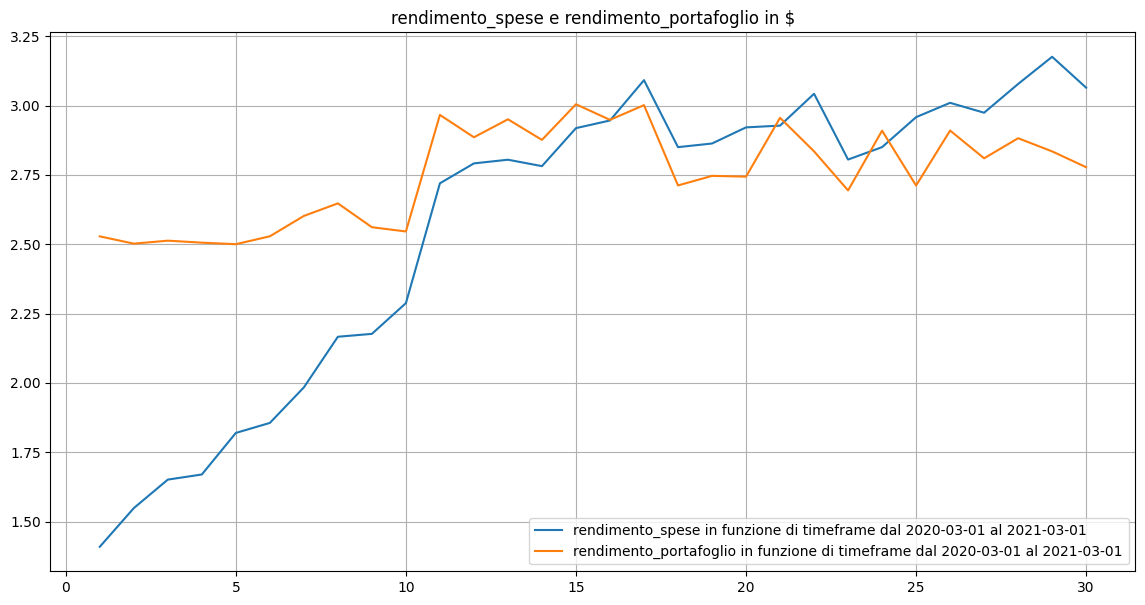

In [29]:
x = range(1, numero_simulazioni + 1)
y1 = lista_rendimenti_spese
y2 = lista_rendimenti_portafoglio
# y3 = lista_rendimenti_miei
plt.figure(figsize=(14, 7))
plt.plot(x, y1, label=f"rendimento_spese in funzione di {nome_variabile} dal {data_inizio} al {data_fine}")
plt.plot(x, y2, label=f"rendimento_portafoglio in funzione di {nome_variabile} dal {data_inizio} al {data_fine}")
# plt.plot(x, y3, label=f"rendimento_mio in funzione di {nome_variabile} dal {data_inizio} al {data_fine}")
plt.title('rendimento_spese e rendimento_portafoglio in $')
plt.grid(True)
plt.legend()
plt.show()

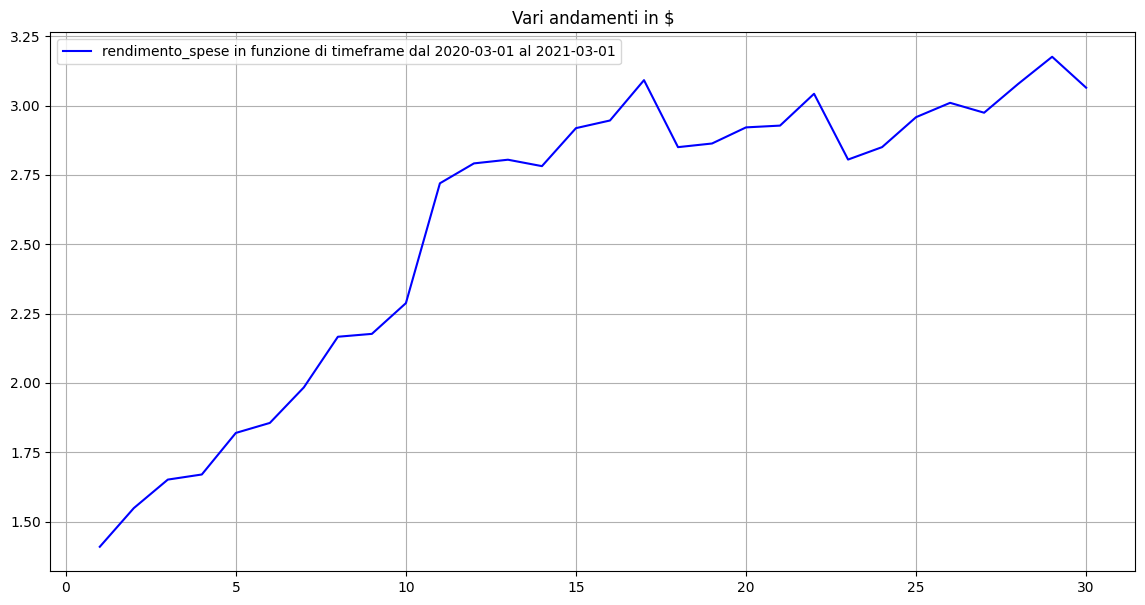

In [30]:
x = range(1, numero_simulazioni + 1)
y = lista_rendimenti_spese
plt.figure(figsize=(14, 7))
plt.plot(x, y, label=f"rendimento_spese in funzione di {nome_variabile} dal {data_inizio} al {data_fine}", color='blue')
plt.title('Vari andamenti in $')
plt.grid(True)
plt.legend()
plt.show()

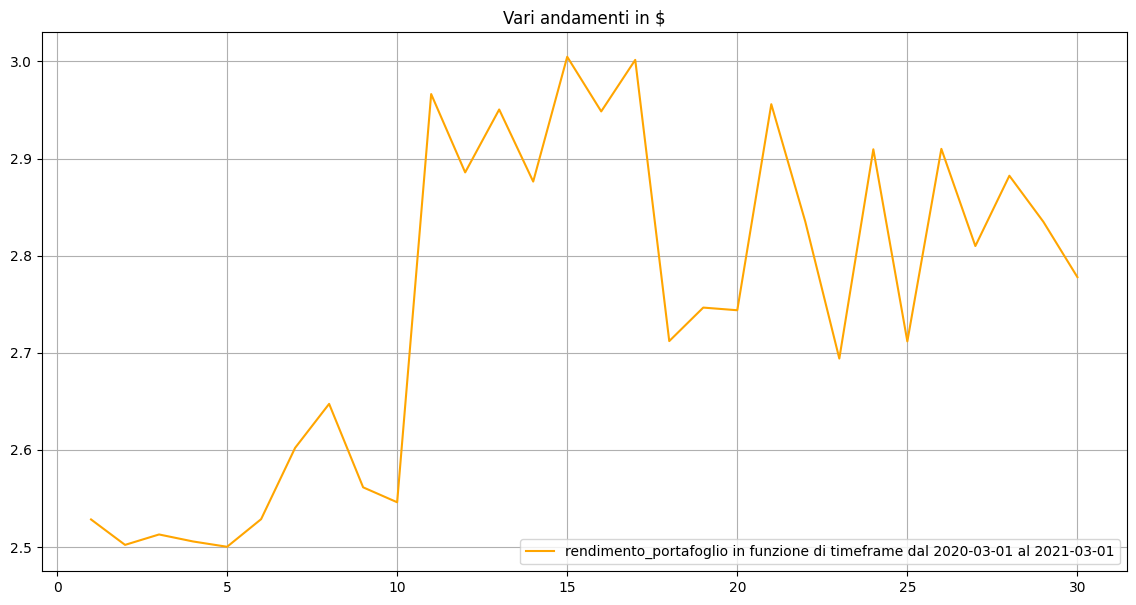

In [31]:
x = range(1, numero_simulazioni + 1)
y = lista_rendimenti_portafoglio
plt.figure(figsize=(14, 7))
plt.plot(x, y, label=f"rendimento_portafoglio in funzione di {nome_variabile} dal {data_inizio} al {data_fine}", color='orange')
plt.title('Vari andamenti in $')
plt.grid(True)
plt.legend()
plt.show()

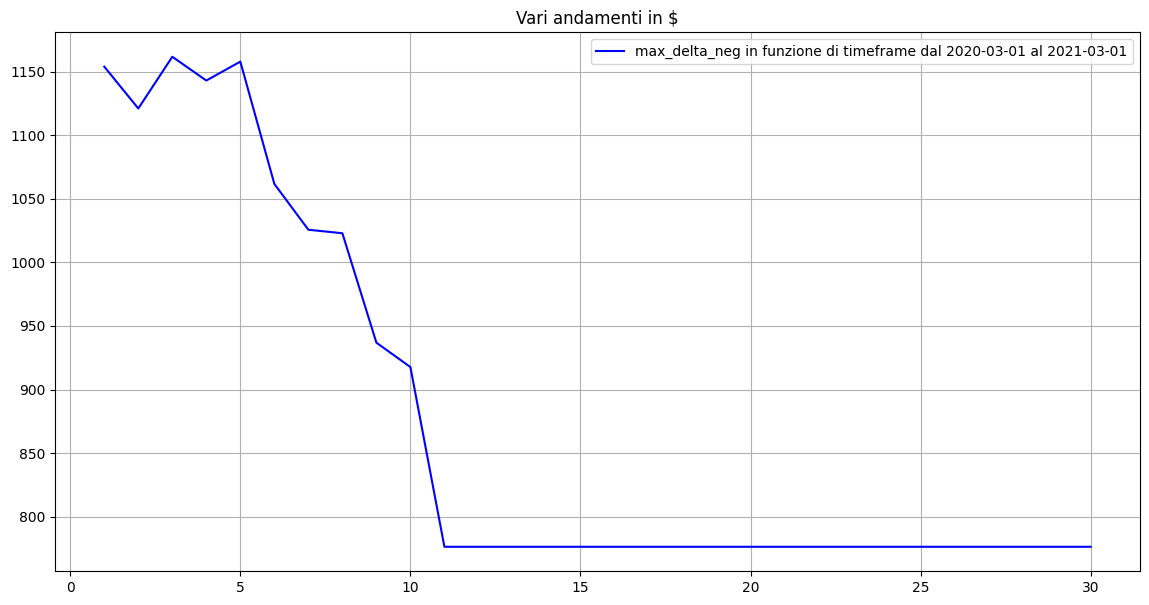

In [32]:
x = range(1,numero_simulazioni + 1)
y = lista_mdn
plt.figure(figsize=(14, 7))
plt.plot(x, y, label=f"max_delta_neg in funzione di {nome_variabile} dal {data_inizio} al {data_fine}", color='blue')
plt.title('Vari andamenti in $')
plt.grid(True)
plt.legend()
plt.show()

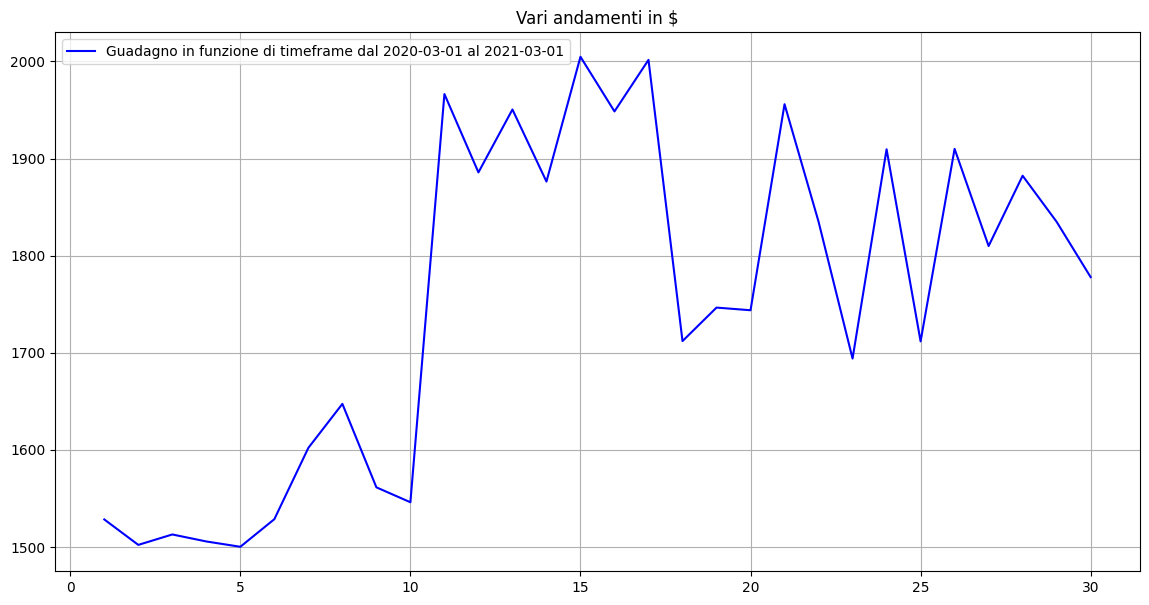

In [33]:
x = range(1,numero_simulazioni + 1)
y = lista_guad
plt.figure(figsize=(14, 7))
plt.plot(x, y, label=f"Guadagno in funzione di {nome_variabile} dal {data_inizio} al {data_fine}", color='blue')
plt.title('Vari andamenti in $')
plt.grid(True)
plt.legend()
plt.show()

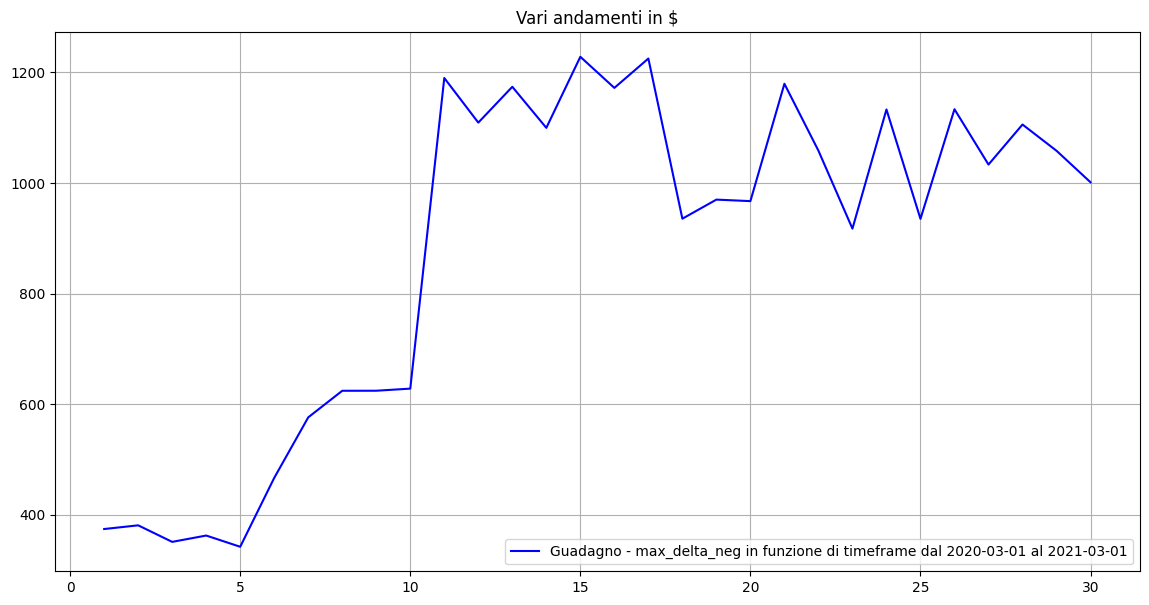

In [34]:
x = range(1,numero_simulazioni + 1)
y = lista_guad_mdn
plt.figure(figsize=(14, 7))
plt.plot(x, y, label=f"Guadagno - max_delta_neg in funzione di {nome_variabile} dal {data_inizio} al {data_fine}", color='blue')
plt.title('Vari andamenti in $')
plt.grid(True)
plt.legend()
plt.show()